uri = wss://192.168.1.19
{'pressure': 1442, 'pavg': 0, 'motor': 51, 'arousal': 141, 'millis': 927032, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1445, 'pavg': 0, 'motor': 56, 'arousal': 118, 'millis': 930799, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1508, 'pavg': 0, 'motor': 47, 'arousal': 161, 'millis': 934599, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1508, 'pavg': 0, 'motor': 54, 'arousal': 127, 'millis': 938345, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1499, 'pavg': 0, 'motor': 49, 'arousal': 152, 'millis': 942145, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1473, 'pavg': 0, 'motor': 49, 'arousal': 151, 'millis': 9

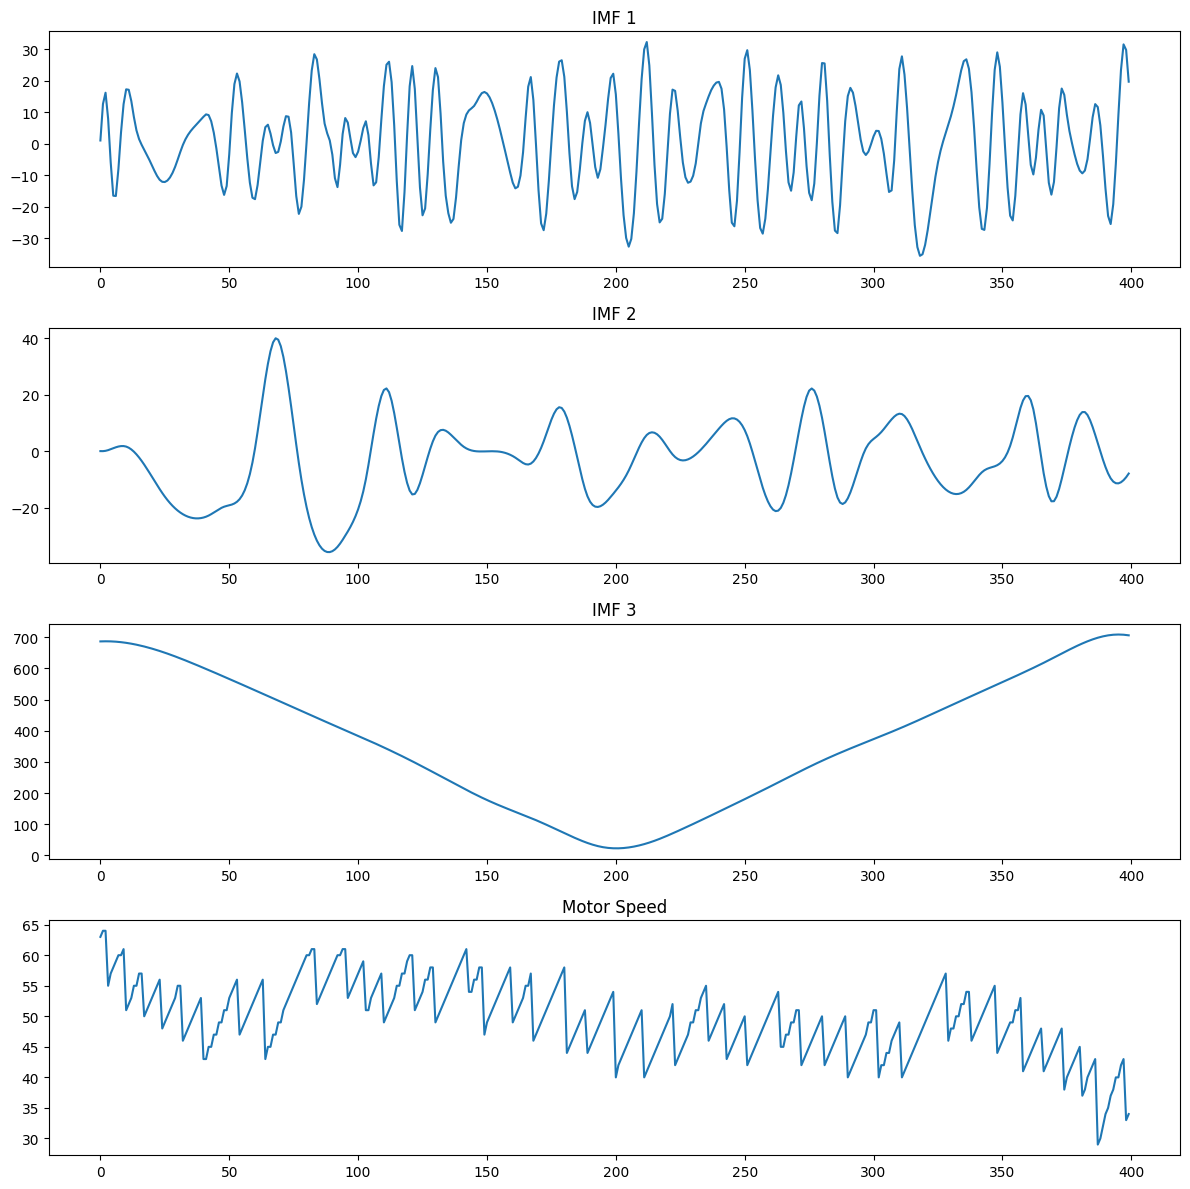

{'pressure': 1455, 'pavg': 0, 'motor': 29, 'arousal': 252, 'millis': 957225, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1515, 'pavg': 0, 'motor': 44, 'arousal': 178, 'millis': 961028, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1497, 'pavg': 0, 'motor': 45, 'arousal': 171, 'millis': 964840, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1481, 'pavg': 0, 'motor': 51, 'arousal': 142, 'millis': 968621, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}


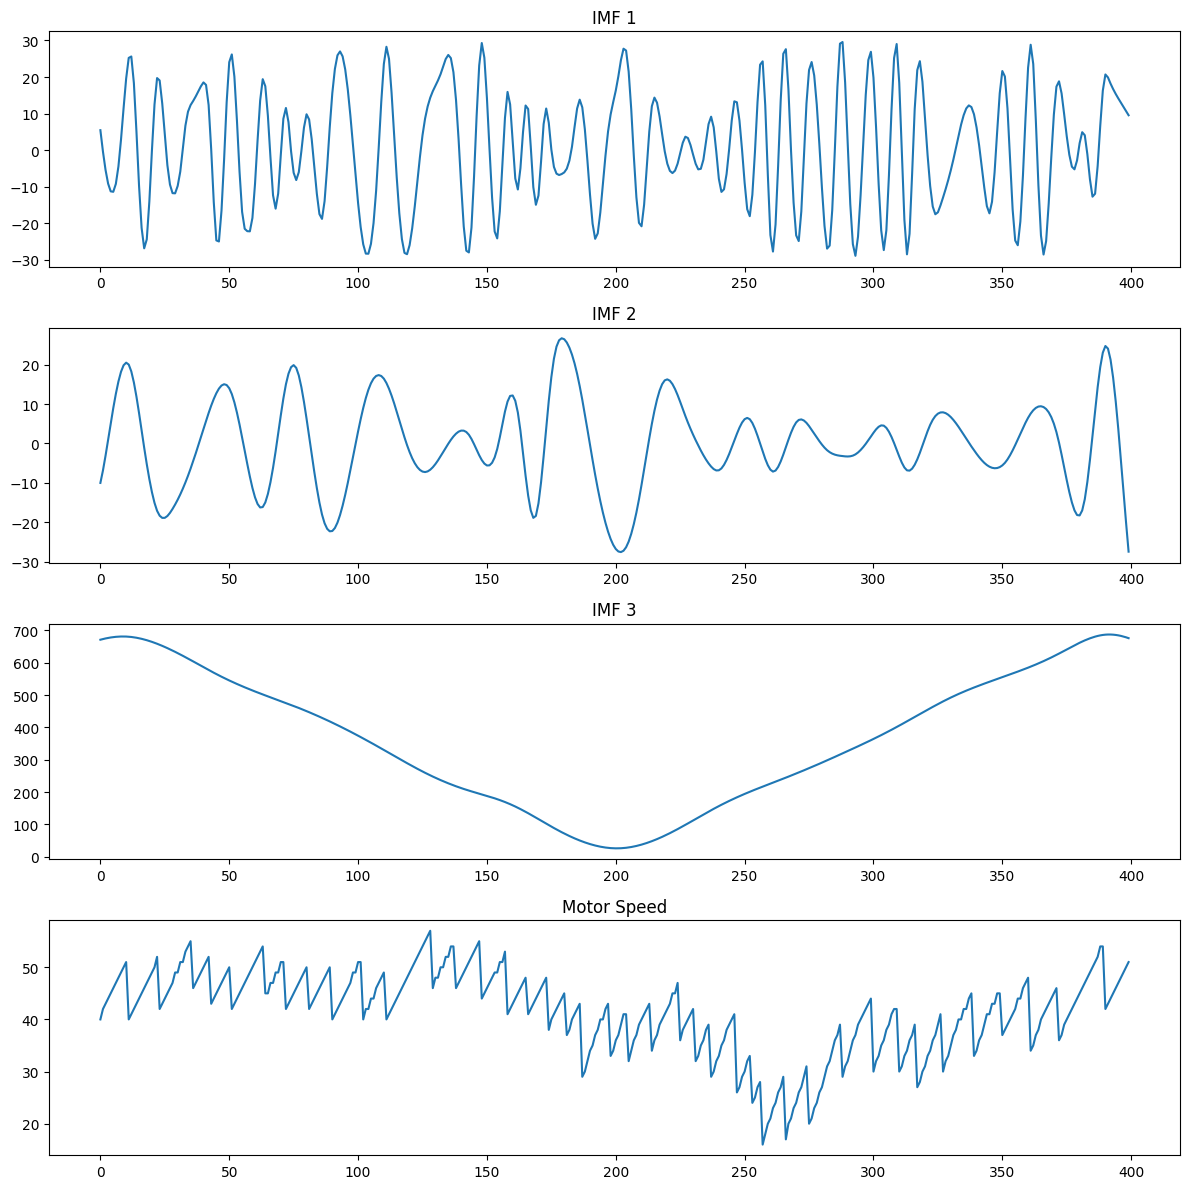

{'pressure': 1454, 'pavg': 0, 'motor': 42, 'arousal': 188, 'millis': 972415, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1491, 'pavg': 0, 'motor': 60, 'arousal': 96, 'millis': 976165, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1509, 'pavg': 0, 'motor': 52, 'arousal': 140, 'millis': 979925, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1445, 'pavg': 0, 'motor': 67, 'arousal': 63, 'millis': 983689, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}


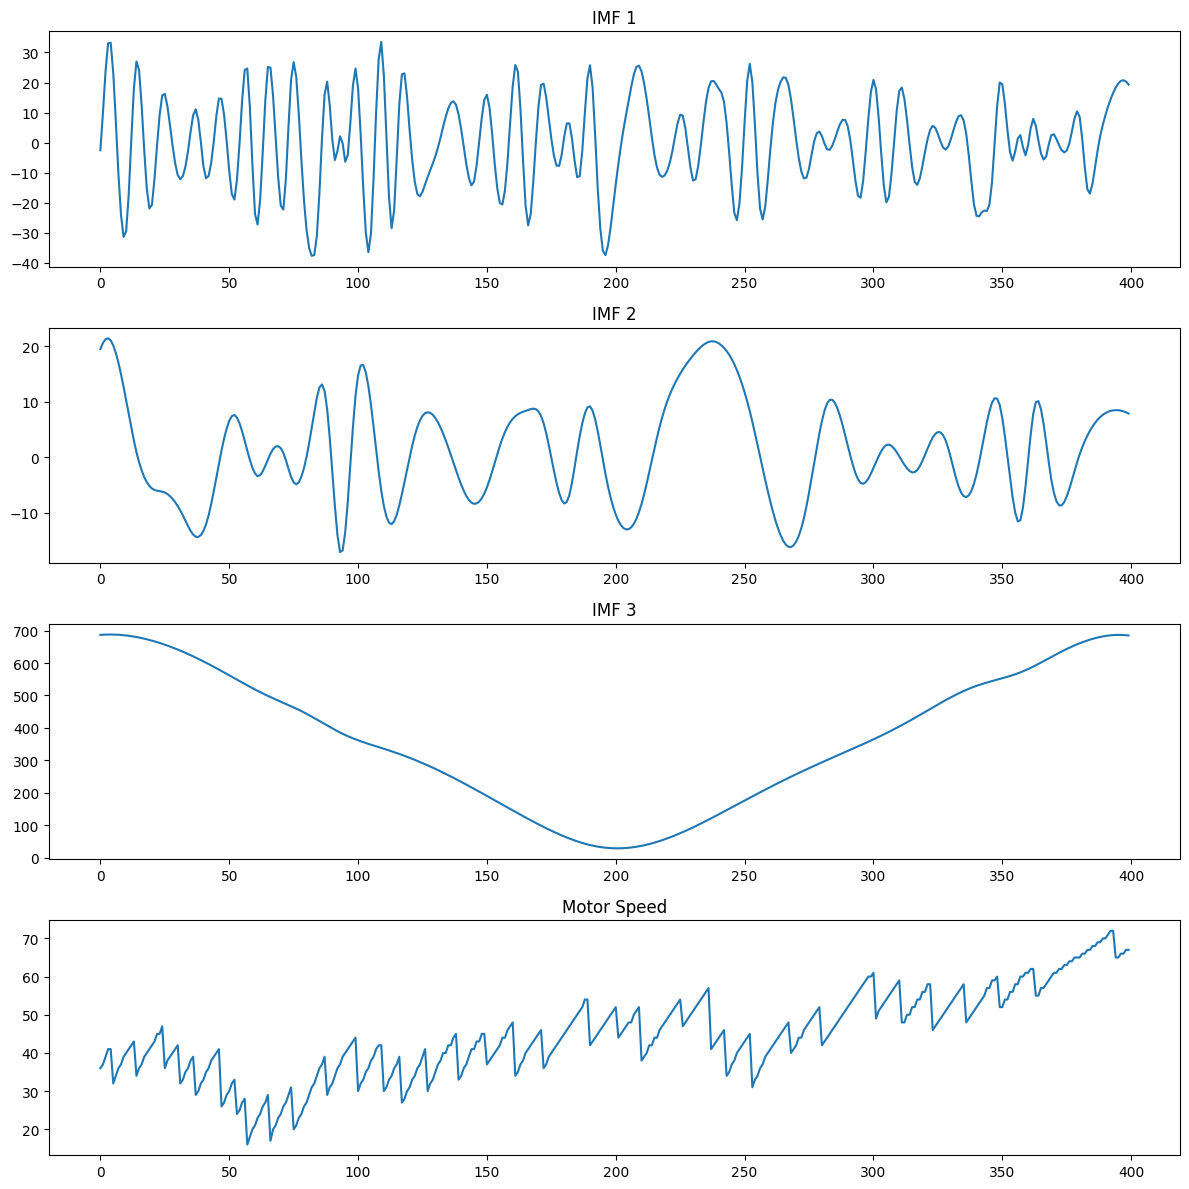

{'pressure': 1429, 'pavg': 0, 'motor': 80, 'arousal': 0, 'millis': 987363, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
{'pressure': 1422, 'pavg': 0, 'motor': 80, 'arousal': 0, 'millis': 990874, 'runMode': 'ORGASM_MODE', 'failedOrgasm': 1, 'permitOrgasm': False, 'postOrgasm': False, 'lock': False}
Signal reçu pour l'arrêt.
Task was cancelled, cleaning up...


In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import asyncio
import websockets
import ssl
import json
from datetime import datetime
import argparse
import signal

#process data into imfs
import emd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import OneHotEncoder


# Handle asyncio event loop re-entry in Jupyter or similar environments
import nest_asyncio
nest_asyncio.apply()

# Global variable to handle cancellation
loop = asyncio.get_event_loop()
stop_event = asyncio.Event()

# global variables
pressure_values = []
motor_values = []
arousal_values = []
window_size = 400
epoch = 0
fig = None
axes = None

# Deep Q-learning parameters
import random
from collections import deque

# Hyperparameters
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
memory = deque(maxlen=10000)
num_actions = 3 # Replace with the number of possible actions

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_dqn_model(input_shape, num_actions):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_actions, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

def train_dqn(batch_size):
    if len(memory) < batch_size:
        return

    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = (reward + gamma *
                      np.amax(dqn_model.predict(next_state)[0]))
        target_f = dqn_model.predict(state)
        target_f[0][action] = target
        dqn_model.fit(state, target_f, epochs=1, verbose=0)
    global epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


async def connect_to_websocket(uri, output_file):
    ssl_context = ssl.SSLContext(ssl.PROTOCOL_TLS_CLIENT)
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    websocket = None
    file = None

    try:
        websocket = await websockets.connect(uri, ssl=ssl_context, ping_interval=None)

        # Send the request to start the stream
        start_stream_message = json.dumps({"streamReadings": 0})
        await websocket.send(start_stream_message)

        #file = open(output_file, 'w')

        while not stop_event.is_set():
            try:
                message = await asyncio.wait_for(websocket.recv(), timeout=1)
                process_message(message)

            except asyncio.TimeoutError:
                continue
            except websockets.exceptions.ConnectionClosedError as e:
                print(f"Connexion fermée : {e}")
                break  # Exit the loop on disconnection
            except Exception as e:
                print(f"Erreur lors de la réception du message : {e}")
                break  # Exit the loop on other errors
    except asyncio.CancelledError:
        print("Task was cancelled, cleaning up...")
    except Exception as e:
        print(f"Erreur de connexion : {e}")
    finally:
        # Ensure the WebSocket connection is closed
        if websocket:
            await websocket.close()
            print("Connexion WebSocket fermée.")

        # Ensure the file is closed
        if file:
            file.close()
            print("Fichier de sortie fermé.")

def calculate_reward(arousal_values,permitOrgasm,failedOrgasm,ajust_motor):
    reward = 0.0
    return reward

def process_message(message):
    global pressure_values
    global motor_values
    global arousal_values
    global epoch
    global window_size
    global fig, axes # Ensure fig and axes are in scope

    last_n_element = 0 - window_size
    #print(message)
    try:
        item = json.loads(message)
        if 'readings' in item:
            epoch += 1
            if epoch % 50 == 0:
                print(f"{item['readings']}")
            pressure_values.append(item['readings']['pressure'])
            motor_values.append(item['readings']['motor'] / 255.0)  # Normalize motor values
            arousal_values.append(item['readings']['arousal'])
            permitOrgasm = item['readings']['permitOrgasm']
            failedOrgasm = item['readings']['failedOrgasm']


            #print(len(pressure_values))

            if len(pressure_values) >= window_size:
               # Calculate moving average
               moving_avg = np.convolve(pressure_values[last_n_element:], np.ones(window_size), 'same') / window_size
               pressure_values_normalized = pressure_values[last_n_element:] - moving_avg

               # Extract IMFs
               imf = np.array([]) # Assign an empty array to imf initially
               imf = emd.sift.sift(np.array(pressure_values_normalized[last_n_element:]))
               #imf = emd.sift.sift(np.array(pressure_values))

               if imf.size > 0:
                  imfs = imf[:, 1:]

                  #print(imfs.size)
                  #print(np.array(pressure_values).reshape(-1, 1).size)
                  #print(np.array(motor_values).reshape(-1, 1).size)

                  # Prepare dataset (consider adding other features if needed)
                  dataset = np.hstack((imfs, np.array(motor_values).reshape(-1, 1)))

                  # Use the dataset for your DQN model here
                  # ...
                  dqn_model_training(dataset)

                  ajust_motor = dqn_model.predict(dataset)

                  reward = calculate_reward(arousal_values,permitOrgasm,failedOrgasm,ajust_motor)

                  # Remove old data to maintain the window size
                  pressure_values = pressure_values[1:]
                  motor_values = motor_values[1:]
                  arousal_values = arousal_values[1:]

                  # Update the plots
                  # Plot the IMFs and motor speed
                  num_imfs = imfs.shape[1] if imf.size > 0 else 0  # Handle case where imf is empty

                  if epoch % 200 == 0:
                    fig, axes = plt.subplots(num_imfs + 1, 1, figsize=(12, 12))

                    # Plot IMFs
                    for i in range(num_imfs):
                      axes[i].plot(imfs[:, i])
                      axes[i].set_title(f"IMF {i+1}")

                    # Plot motor speed in the last subplot
                    axes[num_imfs].plot(np.array(motor_values[last_n_element:]) * 255)
                    axes[num_imfs].set_title('Motor Speed')

                    # Plot arousal in the last subplot
                    #axes[num_imfs+1].plot(arousal)
                    #axes[num_imfs+1].set_title('arousal')
                    plt.tight_layout()
                    plt.show()

    except json.JSONDecodeError:
        pass

    return None

def shutdown(signal_received, frame):
    print("Signal reçu pour l'arrêt.")
    stop_event.set()
    for task in asyncio.all_tasks(loop):
        task.cancel()

if __name__ == "__main__":
    uri = "wss://" + "192.168.1.19"

    print(f"uri = {uri}")
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"stream_output_{current_time}.txt"

    # Register the signal handler
    signal.signal(signal.SIGINT, shutdown)
    signal.signal(signal.SIGTERM, shutdown)

    try:
        loop.run_until_complete(connect_to_websocket(uri, output_file))
    except asyncio.CancelledError:
        pass
    finally:
        if not loop.is_running():
            loop.close()
        print("Programme arrêté.")
